<a href="https://colab.research.google.com/github/silviaarellanogarcia/HackEPS2022/blob/main/Copy_of_Copy_of_Copy_of_missi%C3%B3_verda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍏 MISSIÓ VERDA 🍏

## Objectius 

Volem que implementeu un model o algoritme que permeti classificar els errors del dataset B. Ens agradaria que mostressiu alguna gràfica de l'entrenament del model (en cas de fer ML) o mètriques qualitatives (accuracy, recall, f1...) i quantitatives (matrius de confusió, ROC curve...).



# Setup

Instal·lant les llibreries

In [1]:
import pandas as pd
import numpy as np

Muntant el nostre drive a google colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Extreure les dades

In [3]:
#!unzip "gdrive/MyDrive/HackEPS2022/data/B.zip" -d "gdrive/MyDrive/HackEPS2022/data/verd"

Carregem les dades del csv del dataset

In [4]:
train_df = pd.read_csv("gdrive/MyDrive/HackEPS2022/data/verd/B/train.csv")
train_df.shape

(9457, 11)

##Preprocessing

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9457 entries, 0 to 9456
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             9457 non-null   int64 
 1   image_path             9457 non-null   object
 2   Taca oli               9457 non-null   int64 
 3   Carrera                9457 non-null   int64 
 4   Agujero                9457 non-null   int64 
 5   Hilo fino horizontal2  9457 non-null   int64 
 6   Tensión horizontal     9457 non-null   int64 
 7   Barrado                9457 non-null   int64 
 8   Borrissol              9457 non-null   int64 
 9   Hilo fino horizontal   9457 non-null   int64 
 10  Punto escapado         9457 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 812.8+ KB


In [6]:
train_df.head(10)

,Unnamed: 0,image_path,Taca oli,Carrera,Agujero,Hilo fino horizontal2,Tensión horizontal,Barrado,Borrissol,Hilo fino horizontal,Punto escapado
0,8140,4aaf06a9-frame0-00-08.95.jpg,0,0,0,1,0,0,0,0,0
1,11389,19c8888a-frame0-00-15.68.jpg,0,0,0,0,0,0,0,0,0
2,1945,aa6dfa7d-frame0-00-22.02.jpg,0,0,0,0,0,0,0,0,0
3,7981,5e93a55a-frame0-00-12.03.jpg,0,0,0,1,0,0,0,0,0
4,9359,d6f0df39-frame0-00-03.39.jpg,0,0,0,0,0,0,0,1,0
5,8391,ba32fbbe-frame0-00-04.45.jpg,0,0,0,1,0,0,0,0,0
6,3299,912a067f-frame0-00-38.28.jpg,0,0,0,0,0,0,0,0,0
7,1744,8f1ffd6e-frame0-00-25.75.jpg,0,0,0,0,0,0,0,0,0
8,173,47b8fa6d-frame0-00-20.79.jpg,0,0,0,0,0,0,0,0,0
9,9970,a7b8f3e0-frame0-00-00.20.jpg,0,0,0,0,0,0,0,1,0


No necesitem la columna Unnamed: 0

In [7]:
train_df = train_df.drop('Unnamed: 0', axis=1)

Canviem el nom de image_path a path per a funcionar igual que els altres challenges

In [8]:
train_df = train_df.rename(columns={'image_path': 'path'})

## Model preprocessing

In [9]:
import cv2, os
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf

Creating a generator in order to consume less RAM.

 

*   Before iterating we shuffle the dataframe so that the model don't get used to a single type.
*   Replacing the path in order to get the image from our drive
*   Reshaping the images to fit to the model training shape needs

In [10]:
IMG_SIZE = 224
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

def get_images():
  shffled_train_df = train_df.sample(frac=1)
  for index, row in shffled_train_df.iterrows():
    path = row.path
    path = f'gdrive/MyDrive/HackEPS2022/data/verd/B/data/{path}'
    try:
        img_arr = cv2.imread(path)
        resized_arr = resize_and_rescale(img_arr) # Reshaping images to preferred size
        yield tf.reshape(resized_arr, (1, 224,224,3)), tf.reshape(tf.convert_to_tensor(row[1:].values, dtype=tf.float32), (1, 9))
    except Exception as e:
        pass

Finally not used, but we created another generator that augment images doing transformations to them. We didn't implement this because then the randomness of each type is lost.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

def augment_images():
  for image, image_tag in get_images():
    yield image, image_tag
    for _ in range(5):
      augmented_image = data_augmentation(image)
      yield augmented_image, image_tag

Creating the dataset from the generator

In [11]:

dataset = tf.data.Dataset.from_generator(
     get_images,
     output_signature=(
         tf.TensorSpec(shape=(1, 224,224,3), dtype=tf.float32),
         tf.TensorSpec(shape=(1, 9), dtype=tf.float32)))

Splitting the dataset into test_dataset and train_dataset, this is done by enumerating all the instances and then getting the ones that their index is divisor by 4.

In [12]:
# Splitting the dataset for training and testing.
def is_test(x, _):
    return x % 4 == 0


def is_train(x, y):
    return not is_test(x, y)


recover = lambda x, y: y

# Split the dataset for training.
test_dataset = dataset.enumerate() \
    .filter(is_test) \
    .map(recover)

# Split the dataset for testing/validation.
train_dataset = dataset.enumerate() \
    .filter(is_train) \
    .map(recover)

## Modeling

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

In [18]:
model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3), padding="same"),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.ReLU(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding="same"),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.ReLU(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.MaxPooling2D(2,2),
# # The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding="same"),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.ReLU(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.MaxPooling2D(2,2),
# # The fourth convolution
tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.ReLU(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.MaxPooling2D(2,2),
# # # The fifth convolution
tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding="same"),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.ReLU(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
# 512 neuron hidden layer
tf.keras.layers.Dense(1024, activation='relu'),
tf.keras.layers.Dense(512, activation='relu'),
# Only 8 output neuron. It will contain a value from 0-8 where they are the errors from missió vermella
tf.keras.layers.Dense(9, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)    

In [ ]:
model2 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=6,
)

In [19]:
opt = Adam(lr=0.0000025)
model.compile(optimizer = opt , loss='categorical_crossentropy', metrics = ['accuracy'])

# Training the model

In [ ]:
history = model.fit(train_dataset,validation_data=test_dataset, epochs=5, batch_size=2048)

Epoch 1/5


      2/Unknown - 1s 386ms/step - loss: 0.1937 - accuracy: 0.5000     

      3/Unknown - 2s 445ms/step - loss: 0.1291 - accuracy: 0.3333

      4/Unknown - 3s 649ms/step - loss: 0.0969 - accuracy: 0.2500

      9/Unknown - 6s 569ms/step - loss: 0.6199 - accuracy: 0.2222

     10/Unknown - 6s 571ms/step - loss: 0.7254 - accuracy: 0.2000

     12/Unknown - 7s 532ms/step - loss: 0.6445 - accuracy: 0.2500

     14/Unknown - 8s 566ms/step - loss: 0.5524 - accuracy: 0.2857

     15/Unknown - 9s 548ms/step - loss: 0.5156 - accuracy: 0.2667

     17/Unknown - 10s 547ms/step - loss: 0.4549 - accuracy: 0.2353

     20/Unknown - 11s 541ms/step - loss: 0.4701 - accuracy: 0.3000

     21/Unknown - 12s 529ms/step - loss: 0.5256 - accuracy: 0.2857

     22/Unknown - 13s 555ms/step - loss: 0.5366 - accuracy: 0.3182

     23/Unknown - 13s 547ms/step - loss: 0.5631 - accuracy: 0.3478

     24/Unknown - 13s 538ms/step - loss: 0.5397 - accuracy: 0.3333

     25/Unknown - 14s 553ms/step - loss: 0.5181 - accuracy: 0.3200

     26/Unknown - 15s 561ms/step - loss: 0.4982 - accuracy: 0.3077

     33/Unknown - 18s 540ms/step - loss: 0.4438 - accuracy: 0.2424

     35/Unknown - 20s 548ms/step - loss: 0.4247 - accuracy: 0.2571

     37/Unknown - 21s 541ms/step - loss: 0.4018 - accuracy: 0.2432

     40/Unknown - 22s 545ms/step - loss: 0.3716 - accuracy: 0.2250

     44/Unknown - 25s 546ms/step - loss: 0.4260 - accuracy: 0.2500

     45/Unknown - 25s 542ms/step - loss: 0.4166 - accuracy: 0.2444

     47/Unknown - 26s 543ms/step - loss: 0.4752 - accuracy: 0.2340

     53/Unknown - 30s 547ms/step - loss: 0.5174 - accuracy: 0.2453

     55/Unknown - 30s 544ms/step - loss: 0.4986 - accuracy: 0.2364

     56/Unknown - 31s 541ms/step - loss: 0.5288 - accuracy: 0.2321

     60/Unknown - 32s 525ms/step - loss: 0.4935 - accuracy: 0.2167

     64/Unknown - 35s 541ms/step - loss: 0.4730 - accuracy: 0.2188

     67/Unknown - 37s 538ms/step - loss: 0.4744 - accuracy: 0.2090

     69/Unknown - 37s 531ms/step - loss: 0.4853 - accuracy: 0.2029

     71/Unknown - 38s 532ms/step - loss: 0.4819 - accuracy: 0.2113

     72/Unknown - 39s 530ms/step - loss: 0.4813 - accuracy: 0.2222

     74/Unknown - 40s 529ms/step - loss: 0.5488 - accuracy: 0.2162

     75/Unknown - 40s 532ms/step - loss: 0.5415 - accuracy: 0.2133

     76/Unknown - 41s 538ms/step - loss: 0.5344 - accuracy: 0.2105

     78/Unknown - 42s 534ms/step - loss: 0.5366 - accuracy: 0.2308

     79/Unknown - 43s 536ms/step - loss: 0.5298 - accuracy: 0.2278

     80/Unknown - 43s 534ms/step - loss: 0.5658 - accuracy: 0.2250

     81/Unknown - 44s 537ms/step - loss: 0.5922 - accuracy: 0.2222

     84/Unknown - 46s 540ms/step - loss: 0.5711 - accuracy: 0.2143

     85/Unknown - 46s 539ms/step - loss: 0.5644 - accuracy: 0.2118

     88/Unknown - 48s 544ms/step - loss: 0.5451 - accuracy: 0.2045

     89/Unknown - 49s 544ms/step - loss: 0.5390 - accuracy: 0.2022

     91/Unknown - 50s 545ms/step - loss: 0.5330 - accuracy: 0.2088

     92/Unknown - 51s 543ms/step - loss: 0.5312 - accuracy: 0.2174

     93/Unknown - 51s 542ms/step - loss: 0.5300 - accuracy: 0.2258

     94/Unknown - 52s 543ms/step - loss: 0.5243 - accuracy: 0.2234

     95/Unknown - 52s 541ms/step - loss: 0.5188 - accuracy: 0.2211

     98/Unknown - 54s 541ms/step - loss: 0.5373 - accuracy: 0.2143

    100/Unknown - 55s 542ms/step - loss: 0.5463 - accuracy: 0.2100

    102/Unknown - 55s 538ms/step - loss: 0.5455 - accuracy: 0.2157

    104/Unknown - 57s 539ms/step - loss: 0.5350 - accuracy: 0.2115

    108/Unknown - 59s 538ms/step - loss: 0.5192 - accuracy: 0.2130

    110/Unknown - 60s 539ms/step - loss: 0.5097 - accuracy: 0.2091

    111/Unknown - 60s 540ms/step - loss: 0.5329 - accuracy: 0.2072

    113/Unknown - 62s 544ms/step - loss: 0.5308 - accuracy: 0.2124

    114/Unknown - 62s 542ms/step - loss: 0.5261 - accuracy: 0.2105

    115/Unknown - 63s 540ms/step - loss: 0.5511 - accuracy: 0.2087

    116/Unknown - 64s 543ms/step - loss: 0.5463 - accuracy: 0.2069

    117/Unknown - 64s 541ms/step - loss: 0.5561 - accuracy: 0.2051

    120/Unknown - 66s 543ms/step - loss: 0.5611 - accuracy: 0.2083

    121/Unknown - 66s 545ms/step - loss: 0.5643 - accuracy: 0.2149

    125/Unknown - 68s 542ms/step - loss: 0.5545 - accuracy: 0.2320

    126/Unknown - 69s 542ms/step - loss: 0.5512 - accuracy: 0.2381

    129/Unknown - 70s 542ms/step - loss: 0.5560 - accuracy: 0.2326

    130/Unknown - 71s 544ms/step - loss: 0.5813 - accuracy: 0.2308

    131/Unknown - 72s 543ms/step - loss: 0.5769 - accuracy: 0.2290

    134/Unknown - 74s 549ms/step - loss: 0.5890 - accuracy: 0.2313

    135/Unknown - 74s 547ms/step - loss: 0.5846 - accuracy: 0.2296

    138/Unknown - 76s 548ms/step - loss: 0.5890 - accuracy: 0.2464

    139/Unknown - 77s 550ms/step - loss: 0.5848 - accuracy: 0.2446

    141/Unknown - 78s 547ms/step - loss: 0.6037 - accuracy: 0.2482

    142/Unknown - 78s 549ms/step - loss: 0.5995 - accuracy: 0.2465

    145/Unknown - 80s 546ms/step - loss: 0.6091 - accuracy: 0.2483

    146/Unknown - 80s 544ms/step - loss: 0.6141 - accuracy: 0.2466

    148/Unknown - 82s 547ms/step - loss: 0.6237 - accuracy: 0.2500

    150/Unknown - 83s 548ms/step - loss: 0.6236 - accuracy: 0.2467

    151/Unknown - 83s 549ms/step - loss: 0.6195 - accuracy: 0.2450

    153/Unknown - 84s 546ms/step - loss: 0.6158 - accuracy: 0.2484

    155/Unknown - 85s 548ms/step - loss: 0.6130 - accuracy: 0.2581

    156/Unknown - 86s 546ms/step - loss: 0.6091 - accuracy: 0.2564

    158/Unknown - 87s 549ms/step - loss: 0.6073 - accuracy: 0.2595

    162/Unknown - 88s 541ms/step - loss: 0.6035 - accuracy: 0.2531

    163/Unknown - 89s 544ms/step - loss: 0.5998 - accuracy: 0.2515

    164/Unknown - 90s 546ms/step - loss: 0.5983 - accuracy: 0.2561

    165/Unknown - 90s 545ms/step - loss: 0.5947 - accuracy: 0.2545

    167/Unknown - 91s 544ms/step - loss: 0.6071 - accuracy: 0.2515

    168/Unknown - 92s 544ms/step - loss: 0.6035 - accuracy: 0.2500

    169/Unknown - 93s 545ms/step - loss: 0.6146 - accuracy: 0.2485

    171/Unknown - 93s 543ms/step - loss: 0.6139 - accuracy: 0.2515

    176/Unknown - 96s 542ms/step - loss: 0.6269 - accuracy: 0.2557

    177/Unknown - 96s 541ms/step - loss: 0.6234 - accuracy: 0.2542

    179/Unknown - 98s 544ms/step - loss: 0.6184 - accuracy: 0.2570

    182/Unknown - 99s 543ms/step - loss: 0.6302 - accuracy: 0.2582

    185/Unknown - 100s 539ms/step - loss: 0.6345 - accuracy: 0.2541

    188/Unknown - 102s 539ms/step - loss: 0.6388 - accuracy: 0.2553

    191/Unknown - 103s 539ms/step - loss: 0.6288 - accuracy: 0.2513

    192/Unknown - 104s 538ms/step - loss: 0.6255 - accuracy: 0.2500

    194/Unknown - 105s 540ms/step - loss: 0.6295 - accuracy: 0.2474

    195/Unknown - 106s 539ms/step - loss: 0.6263 - accuracy: 0.2462

    196/Unknown - 106s 538ms/step - loss: 0.6231 - accuracy: 0.2449

    197/Unknown - 107s 538ms/step - loss: 0.6199 - accuracy: 0.2437

    198/Unknown - 107s 538ms/step - loss: 0.6295 - accuracy: 0.2424

    200/Unknown - 108s 539ms/step - loss: 0.6463 - accuracy: 0.2450

    202/Unknown - 110s 541ms/step - loss: 0.6399 - accuracy: 0.2426

    203/Unknown - 111s 542ms/step - loss: 0.6411 - accuracy: 0.2463

    205/Unknown - 112s 544ms/step - loss: 0.6477 - accuracy: 0.2488

    207/Unknown - 113s 542ms/step - loss: 0.6515 - accuracy: 0.2464

    210/Unknown - 114s 542ms/step - loss: 0.6422 - accuracy: 0.2429

    211/Unknown - 115s 544ms/step - loss: 0.6392 - accuracy: 0.2417

    212/Unknown - 116s 543ms/step - loss: 0.6394 - accuracy: 0.2453

    214/Unknown - 117s 543ms/step - loss: 0.6612 - accuracy: 0.2430

    216/Unknown - 118s 543ms/step - loss: 0.6617 - accuracy: 0.2500

    218/Unknown - 119s 543ms/step - loss: 0.6557 - accuracy: 0.2477

    219/Unknown - 119s 543ms/step - loss: 0.6539 - accuracy: 0.2511

    222/Unknown - 122s 545ms/step - loss: 0.6699 - accuracy: 0.2477

    226/Unknown - 123s 544ms/step - loss: 0.6866 - accuracy: 0.2478

    227/Unknown - 124s 543ms/step - loss: 0.6835 - accuracy: 0.2467

    228/Unknown - 124s 542ms/step - loss: 0.6805 - accuracy: 0.2456

    231/Unknown - 126s 542ms/step - loss: 0.6717 - accuracy: 0.2424

    233/Unknown - 127s 544ms/step - loss: 0.6659 - accuracy: 0.2403

    234/Unknown - 128s 543ms/step - loss: 0.6631 - accuracy: 0.2393

    237/Unknown - 129s 544ms/step - loss: 0.6984 - accuracy: 0.2363

    238/Unknown - 130s 545ms/step - loss: 0.6955 - accuracy: 0.2353

    240/Unknown - 131s 545ms/step - loss: 0.6980 - accuracy: 0.2333

    243/Unknown - 133s 544ms/step - loss: 0.6980 - accuracy: 0.2305

    244/Unknown - 134s 546ms/step - loss: 0.6961 - accuracy: 0.2336

    249/Unknown - 136s 543ms/step - loss: 0.7358 - accuracy: 0.2289

    251/Unknown - 137s 543ms/step - loss: 0.7305 - accuracy: 0.2351

    252/Unknown - 137s 542ms/step - loss: 0.7276 - accuracy: 0.2341

    254/Unknown - 138s 543ms/step - loss: 0.7265 - accuracy: 0.2323

    258/Unknown - 141s 543ms/step - loss: 0.7562 - accuracy: 0.2287

    262/Unknown - 143s 544ms/step - loss: 0.7590 - accuracy: 0.2328

    263/Unknown - 143s 543ms/step - loss: 0.7561 - accuracy: 0.2319

    266/Unknown - 145s 543ms/step - loss: 0.7483 - accuracy: 0.2331

    267/Unknown - 145s 543ms/step - loss: 0.7455 - accuracy: 0.2322

    269/Unknown - 147s 543ms/step - loss: 0.7502 - accuracy: 0.2305

    270/Unknown - 147s 543ms/step - loss: 0.7474 - accuracy: 0.2296

    271/Unknown - 148s 545ms/step - loss: 0.7624 - accuracy: 0.2288

    272/Unknown - 148s 544ms/step - loss: 0.7596 - accuracy: 0.2279

    274/Unknown - 150s 545ms/step - loss: 0.7541 - accuracy: 0.2263

    276/Unknown - 151s 543ms/step - loss: 0.7486 - accuracy: 0.2246

    277/Unknown - 151s 545ms/step - loss: 0.7459 - accuracy: 0.2238

    279/Unknown - 152s 543ms/step - loss: 0.7406 - accuracy: 0.2222

    280/Unknown - 152s 542ms/step - loss: 0.7415 - accuracy: 0.2250

    282/Unknown - 153s 541ms/step - loss: 0.7424 - accuracy: 0.2234

    288/Unknown - 156s 540ms/step - loss: 0.7449 - accuracy: 0.2292

    289/Unknown - 157s 541ms/step - loss: 0.7423 - accuracy: 0.2284

    291/Unknown - 158s 541ms/step - loss: 0.7372 - accuracy: 0.2268

    292/Unknown - 159s 542ms/step - loss: 0.7347 - accuracy: 0.2260

    294/Unknown - 160s 541ms/step - loss: 0.7316 - accuracy: 0.2279

    296/Unknown - 161s 544ms/step - loss: 0.7329 - accuracy: 0.2264

    297/Unknown - 162s 544ms/step - loss: 0.7437 - accuracy: 0.2290

    300/Unknown - 163s 541ms/step - loss: 0.7460 - accuracy: 0.2333

    302/Unknown - 164s 541ms/step - loss: 0.7459 - accuracy: 0.2351

    304/Unknown - 165s 539ms/step - loss: 0.7450 - accuracy: 0.2336

    309/Unknown - 167s 538ms/step - loss: 0.7420 - accuracy: 0.2330

    310/Unknown - 167s 538ms/step - loss: 0.7451 - accuracy: 0.2323

    312/Unknown - 169s 538ms/step - loss: 0.7403 - accuracy: 0.2308

    316/Unknown - 171s 538ms/step - loss: 0.7356 - accuracy: 0.2373

    317/Unknown - 171s 538ms/step - loss: 0.7333 - accuracy: 0.2366

    318/Unknown - 171s 537ms/step - loss: 0.7429 - accuracy: 0.2358

    320/Unknown - 172s 537ms/step - loss: 0.7425 - accuracy: 0.2344

    321/Unknown - 173s 537ms/step - loss: 0.7402 - accuracy: 0.2336

    324/Unknown - 174s 535ms/step - loss: 0.7413 - accuracy: 0.2315

    327/Unknown - 176s 535ms/step - loss: 0.7367 - accuracy: 0.2324

    330/Unknown - 178s 537ms/step - loss: 0.7465 - accuracy: 0.2303

    333/Unknown - 179s 537ms/step - loss: 0.7409 - accuracy: 0.2342

    334/Unknown - 181s 539ms/step - loss: 0.7414 - accuracy: 0.2365

    336/Unknown - 181s 538ms/step - loss: 0.7370 - accuracy: 0.2351

    337/Unknown - 182s 538ms/step - loss: 0.7348 - accuracy: 0.2344

    338/Unknown - 182s 538ms/step - loss: 0.7354 - accuracy: 0.2367

    340/Unknown - 184s 538ms/step - loss: 0.7368 - accuracy: 0.2412

    341/Unknown - 184s 538ms/step - loss: 0.7457 - accuracy: 0.2434

    342/Unknown - 185s 538ms/step - loss: 0.7515 - accuracy: 0.2427

    345/Unknown - 187s 539ms/step - loss: 0.7479 - accuracy: 0.2435

    348/Unknown - 188s 538ms/step - loss: 0.7415 - accuracy: 0.2414

    349/Unknown - 189s 539ms/step - loss: 0.7394 - accuracy: 0.2407

    351/Unknown - 190s 539ms/step - loss: 0.7454 - accuracy: 0.2393

    355/Unknown - 192s 540ms/step - loss: 0.7382 - accuracy: 0.2394

    357/Unknown - 193s 539ms/step - loss: 0.7379 - accuracy: 0.2381

    358/Unknown - 193s 539ms/step - loss: 0.7359 - accuracy: 0.2374

    360/Unknown - 194s 538ms/step - loss: 0.7318 - accuracy: 0.2361

    361/Unknown - 195s 538ms/step - loss: 0.7316 - accuracy: 0.2382

    362/Unknown - 196s 539ms/step - loss: 0.7340 - accuracy: 0.2376

    366/Unknown - 197s 537ms/step - loss: 0.7374 - accuracy: 0.2350

    367/Unknown - 198s 537ms/step - loss: 0.7354 - accuracy: 0.2371

    368/Unknown - 198s 537ms/step - loss: 0.7369 - accuracy: 0.2364

    370/Unknown - 199s 536ms/step - loss: 0.7329 - accuracy: 0.2351

    371/Unknown - 200s 537ms/step - loss: 0.7309 - accuracy: 0.2372

    373/Unknown - 201s 537ms/step - loss: 0.7341 - accuracy: 0.2386

    374/Unknown - 201s 537ms/step - loss: 0.7370 - accuracy: 0.2380

    375/Unknown - 202s 536ms/step - loss: 0.7350 - accuracy: 0.2373

    377/Unknown - 203s 536ms/step - loss: 0.7325 - accuracy: 0.2387

    381/Unknown - 205s 536ms/step - loss: 0.7289 - accuracy: 0.2362

    382/Unknown - 206s 537ms/step - loss: 0.7292 - accuracy: 0.2382

    383/Unknown - 206s 537ms/step - loss: 0.7373 - accuracy: 0.2376

    384/Unknown - 207s 537ms/step - loss: 0.7354 - accuracy: 0.2370

    385/Unknown - 208s 538ms/step - loss: 0.7335 - accuracy: 0.2364

    388/Unknown - 209s 537ms/step - loss: 0.7390 - accuracy: 0.2371

    391/Unknown - 211s 537ms/step - loss: 0.7333 - accuracy: 0.2353

    393/Unknown - 211s 536ms/step - loss: 0.7312 - accuracy: 0.2366

    394/Unknown - 212s 536ms/step - loss: 0.7294 - accuracy: 0.2360

    395/Unknown - 213s 537ms/step - loss: 0.7324 - accuracy: 0.2354

    396/Unknown - 213s 536ms/step - loss: 0.7305 - accuracy: 0.2348

    398/Unknown - 214s 536ms/step - loss: 0.7315 - accuracy: 0.2337

    402/Unknown - 216s 535ms/step - loss: 0.7364 - accuracy: 0.2338

    405/Unknown - 217s 535ms/step - loss: 0.7310 - accuracy: 0.2321

    407/Unknown - 218s 535ms/step - loss: 0.7305 - accuracy: 0.2334

    408/Unknown - 218s 534ms/step - loss: 0.7287 - accuracy: 0.2328

    409/Unknown - 219s 534ms/step - loss: 0.7269 - accuracy: 0.2323

    410/Unknown - 220s 534ms/step - loss: 0.7252 - accuracy: 0.2317

    412/Unknown - 221s 535ms/step - loss: 0.7261 - accuracy: 0.2306

    415/Unknown - 222s 534ms/step - loss: 0.7209 - accuracy: 0.2289

    419/Unknown - 224s 534ms/step - loss: 0.7156 - accuracy: 0.2291

    420/Unknown - 225s 533ms/step - loss: 0.7156 - accuracy: 0.2310

    424/Unknown - 227s 533ms/step - loss: 0.7088 - accuracy: 0.2288

    425/Unknown - 227s 534ms/step - loss: 0.7072 - accuracy: 0.2306

    429/Unknown - 229s 533ms/step - loss: 0.7048 - accuracy: 0.2284

    430/Unknown - 230s 534ms/step - loss: 0.7032 - accuracy: 0.2279

    432/Unknown - 231s 532ms/step - loss: 0.7111 - accuracy: 0.2269

    435/Unknown - 232s 531ms/step - loss: 0.7213 - accuracy: 0.2253

    437/Unknown - 233s 531ms/step - loss: 0.7180 - accuracy: 0.2243

    439/Unknown - 234s 531ms/step - loss: 0.7197 - accuracy: 0.2232

    440/Unknown - 234s 531ms/step - loss: 0.7216 - accuracy: 0.2227

    441/Unknown - 235s 531ms/step - loss: 0.7200 - accuracy: 0.2222

    445/Unknown - 237s 530ms/step - loss: 0.7184 - accuracy: 0.2202

    446/Unknown - 237s 530ms/step - loss: 0.7168 - accuracy: 0.2220

    448/Unknown - 238s 530ms/step - loss: 0.7219 - accuracy: 0.2210

    449/Unknown - 238s 530ms/step - loss: 0.7280 - accuracy: 0.2205

    452/Unknown - 240s 529ms/step - loss: 0.7299 - accuracy: 0.2190

    456/Unknown - 241s 528ms/step - loss: 0.7315 - accuracy: 0.2215

    459/Unknown - 243s 528ms/step - loss: 0.7350 - accuracy: 0.2222

    461/Unknown - 244s 528ms/step - loss: 0.7365 - accuracy: 0.2234

    462/Unknown - 244s 528ms/step - loss: 0.7353 - accuracy: 0.2251

    464/Unknown - 246s 529ms/step - loss: 0.7335 - accuracy: 0.2263

    467/Unknown - 248s 529ms/step - loss: 0.7288 - accuracy: 0.2270

    468/Unknown - 248s 528ms/step - loss: 0.7272 - accuracy: 0.2265

    469/Unknown - 248s 528ms/step - loss: 0.7257 - accuracy: 0.2260

    470/Unknown - 249s 529ms/step - loss: 0.7336 - accuracy: 0.2255

    471/Unknown - 250s 529ms/step - loss: 0.7359 - accuracy: 0.2251

    472/Unknown - 250s 529ms/step - loss: 0.7343 - accuracy: 0.2246

    474/Unknown - 251s 529ms/step - loss: 0.7312 - accuracy: 0.2236

    475/Unknown - 252s 529ms/step - loss: 0.7297 - accuracy: 0.2232

    476/Unknown - 252s 529ms/step - loss: 0.7281 - accuracy: 0.2227

    477/Unknown - 253s 529ms/step - loss: 0.7266 - accuracy: 0.2222

    478/Unknown - 253s 529ms/step - loss: 0.7251 - accuracy: 0.2218

    480/Unknown - 254s 528ms/step - loss: 0.7242 - accuracy: 0.2208

    481/Unknown - 255s 529ms/step - loss: 0.7260 - accuracy: 0.2204

    484/Unknown - 256s 528ms/step - loss: 0.7236 - accuracy: 0.2211

    487/Unknown - 257s 527ms/step - loss: 0.7197 - accuracy: 0.2218

    488/Unknown - 258s 527ms/step - loss: 0.7182 - accuracy: 0.2213

    489/Unknown - 258s 526ms/step - loss: 0.7205 - accuracy: 0.2209

    491/Unknown - 259s 527ms/step - loss: 0.7241 - accuracy: 0.2220

    492/Unknown - 260s 527ms/step - loss: 0.7242 - accuracy: 0.2236

    494/Unknown - 261s 527ms/step - loss: 0.7308 - accuracy: 0.2227

    496/Unknown - 262s 527ms/step - loss: 0.7341 - accuracy: 0.2218

    497/Unknown - 262s 527ms/step - loss: 0.7326 - accuracy: 0.2213

    498/Unknown - 263s 527ms/step - loss: 0.7311 - accuracy: 0.2209

    499/Unknown - 263s 527ms/step - loss: 0.7297 - accuracy: 0.2204

    503/Unknown - 265s 526ms/step - loss: 0.7369 - accuracy: 0.2187

    504/Unknown - 266s 526ms/step - loss: 0.7354 - accuracy: 0.2202

    506/Unknown - 267s 526ms/step - loss: 0.7325 - accuracy: 0.2194

    507/Unknown - 267s 526ms/step - loss: 0.7311 - accuracy: 0.2209

    508/Unknown - 268s 527ms/step - loss: 0.7305 - accuracy: 0.2224

    509/Unknown - 269s 527ms/step - loss: 0.7290 - accuracy: 0.2220

    510/Unknown - 269s 527ms/step - loss: 0.7276 - accuracy: 0.2216

    511/Unknown - 270s 527ms/step - loss: 0.7273 - accuracy: 0.2231

    512/Unknown - 271s 528ms/step - loss: 0.7259 - accuracy: 0.2227

    514/Unknown - 272s 528ms/step - loss: 0.7279 - accuracy: 0.2237

    515/Unknown - 273s 528ms/step - loss: 0.7297 - accuracy: 0.2233

    516/Unknown - 273s 528ms/step - loss: 0.7283 - accuracy: 0.2229

    519/Unknown - 274s 528ms/step - loss: 0.7285 - accuracy: 0.2235

    523/Unknown - 277s 528ms/step - loss: 0.7262 - accuracy: 0.2237

    527/Unknown - 279s 529ms/step - loss: 0.7226 - accuracy: 0.2258

    529/Unknown - 280s 528ms/step - loss: 0.7223 - accuracy: 0.2250

    530/Unknown - 280s 528ms/step - loss: 0.7209 - accuracy: 0.2245

    531/Unknown - 281s 527ms/step - loss: 0.7264 - accuracy: 0.2241

    537/Unknown - 283s 527ms/step - loss: 0.7194 - accuracy: 0.2235

    540/Unknown - 285s 527ms/step - loss: 0.7235 - accuracy: 0.2222

    543/Unknown - 287s 527ms/step - loss: 0.7203 - accuracy: 0.2228

    546/Unknown - 289s 528ms/step - loss: 0.7246 - accuracy: 0.2216

    547/Unknown - 290s 529ms/step - loss: 0.7232 - accuracy: 0.2212

    548/Unknown - 290s 528ms/step - loss: 0.7219 - accuracy: 0.2208

    549/Unknown - 291s 528ms/step - loss: 0.7206 - accuracy: 0.2204

    550/Unknown - 291s 529ms/step - loss: 0.7193 - accuracy: 0.2200

    552/Unknown - 292s 529ms/step - loss: 0.7184 - accuracy: 0.2210

    555/Unknown - 294s 528ms/step - loss: 0.7145 - accuracy: 0.2198

    556/Unknown - 295s 529ms/step - loss: 0.7143 - accuracy: 0.2212

    557/Unknown - 295s 529ms/step - loss: 0.7130 - accuracy: 0.2208

    558/Unknown - 296s 529ms/step - loss: 0.7137 - accuracy: 0.2204

    563/Unknown - 298s 529ms/step - loss: 0.7142 - accuracy: 0.2185

    564/Unknown - 299s 529ms/step - loss: 0.7130 - accuracy: 0.2181

    565/Unknown - 300s 529ms/step - loss: 0.7168 - accuracy: 0.2177

    566/Unknown - 300s 529ms/step - loss: 0.7190 - accuracy: 0.2173

    568/Unknown - 302s 530ms/step - loss: 0.7197 - accuracy: 0.2165

    570/Unknown - 302s 529ms/step - loss: 0.7221 - accuracy: 0.2158

    571/Unknown - 303s 530ms/step - loss: 0.7209 - accuracy: 0.2154

    573/Unknown - 304s 530ms/step - loss: 0.7188 - accuracy: 0.2164

    576/Unknown - 306s 530ms/step - loss: 0.7289 - accuracy: 0.2170

    577/Unknown - 306s 530ms/step - loss: 0.7283 - accuracy: 0.2184

    578/Unknown - 307s 530ms/step - loss: 0.7270 - accuracy: 0.2180

    579/Unknown - 307s 530ms/step - loss: 0.7325 - accuracy: 0.2176

    581/Unknown - 308s 529ms/step - loss: 0.7300 - accuracy: 0.2186

    582/Unknown - 308s 529ms/step - loss: 0.7300 - accuracy: 0.2199

    587/Unknown - 311s 528ms/step - loss: 0.7286 - accuracy: 0.2181

    588/Unknown - 311s 528ms/step - loss: 0.7274 - accuracy: 0.2177

    589/Unknown - 312s 529ms/step - loss: 0.7261 - accuracy: 0.2173

    591/Unknown - 313s 529ms/step - loss: 0.7246 - accuracy: 0.2200

    593/Unknown - 315s 530ms/step - loss: 0.7221 - accuracy: 0.2226

    594/Unknown - 315s 529ms/step - loss: 0.7209 - accuracy: 0.2222

    595/Unknown - 316s 530ms/step - loss: 0.7197 - accuracy: 0.2218

    596/Unknown - 316s 530ms/step - loss: 0.7185 - accuracy: 0.2215

    597/Unknown - 317s 530ms/step - loss: 0.7173 - accuracy: 0.2211

    600/Unknown - 318s 528ms/step - loss: 0.7215 - accuracy: 0.2200

    606/Unknown - 321s 528ms/step - loss: 0.7206 - accuracy: 0.2211

    607/Unknown - 321s 528ms/step - loss: 0.7194 - accuracy: 0.2208

    608/Unknown - 322s 528ms/step - loss: 0.7182 - accuracy: 0.2204

    609/Unknown - 322s 528ms/step - loss: 0.7170 - accuracy: 0.2200

    610/Unknown - 323s 529ms/step - loss: 0.7241 - accuracy: 0.2197

    611/Unknown - 323s 528ms/step - loss: 0.7229 - accuracy: 0.2193

    612/Unknown - 324s 528ms/step - loss: 0.7217 - accuracy: 0.2206

    615/Unknown - 325s 528ms/step - loss: 0.7195 - accuracy: 0.2211

    617/Unknown - 327s 528ms/step - loss: 0.7172 - accuracy: 0.2204

    618/Unknown - 327s 528ms/step - loss: 0.7206 - accuracy: 0.2217

    620/Unknown - 328s 529ms/step - loss: 0.7232 - accuracy: 0.2210

    621/Unknown - 329s 529ms/step - loss: 0.7220 - accuracy: 0.2206

    624/Unknown - 330s 528ms/step - loss: 0.7263 - accuracy: 0.2212

    627/Unknown - 332s 528ms/step - loss: 0.7296 - accuracy: 0.2201

    628/Unknown - 333s 529ms/step - loss: 0.7328 - accuracy: 0.2197

    629/Unknown - 333s 528ms/step - loss: 0.7341 - accuracy: 0.2194

    631/Unknown - 334s 528ms/step - loss: 0.7322 - accuracy: 0.2203

    632/Unknown - 334s 528ms/step - loss: 0.7310 - accuracy: 0.2199

    633/Unknown - 335s 528ms/step - loss: 0.7299 - accuracy: 0.2196

    634/Unknown - 336s 528ms/step - loss: 0.7294 - accuracy: 0.2208

    635/Unknown - 336s 528ms/step - loss: 0.7283 - accuracy: 0.2205

    636/Unknown - 337s 528ms/step - loss: 0.7272 - accuracy: 0.2201

    640/Unknown - 339s 528ms/step - loss: 0.7287 - accuracy: 0.2203

    643/Unknown - 341s 529ms/step - loss: 0.7317 - accuracy: 0.2193

    645/Unknown - 341s 529ms/step - loss: 0.7303 - accuracy: 0.2202

    646/Unknown - 342s 529ms/step - loss: 0.7327 - accuracy: 0.2198

    647/Unknown - 343s 529ms/step - loss: 0.7323 - accuracy: 0.2210

    648/Unknown - 343s 528ms/step - loss: 0.7312 - accuracy: 0.2207

    649/Unknown - 344s 529ms/step - loss: 0.7321 - accuracy: 0.2203

    651/Unknown - 344s 528ms/step - loss: 0.7313 - accuracy: 0.2212

    653/Unknown - 346s 529ms/step - loss: 0.7324 - accuracy: 0.2221

    654/Unknown - 346s 529ms/step - loss: 0.7315 - accuracy: 0.2232

    655/Unknown - 347s 529ms/step - loss: 0.7395 - accuracy: 0.2229

    660/Unknown - 349s 528ms/step - loss: 0.7418 - accuracy: 0.2212

    662/Unknown - 350s 528ms/step - loss: 0.7477 - accuracy: 0.2205

    664/Unknown - 351s 528ms/step - loss: 0.7454 - accuracy: 0.2214

    665/Unknown - 352s 528ms/step - loss: 0.7443 - accuracy: 0.2211

    666/Unknown - 352s 528ms/step - loss: 0.7432 - accuracy: 0.2207

    669/Unknown - 354s 528ms/step - loss: 0.7405 - accuracy: 0.2227

    671/Unknown - 355s 528ms/step - loss: 0.7383 - accuracy: 0.2221

    673/Unknown - 355s 527ms/step - loss: 0.7361 - accuracy: 0.2214

    678/Unknown - 358s 527ms/step - loss: 0.7317 - accuracy: 0.2212

    682/Unknown - 360s 527ms/step - loss: 0.7330 - accuracy: 0.2199

    684/Unknown - 361s 527ms/step - loss: 0.7309 - accuracy: 0.2193

    687/Unknown - 362s 526ms/step - loss: 0.7315 - accuracy: 0.2213

    688/Unknown - 363s 526ms/step - loss: 0.7304 - accuracy: 0.2209

    692/Unknown - 365s 526ms/step - loss: 0.7299 - accuracy: 0.2211

    694/Unknown - 366s 526ms/step - loss: 0.7278 - accuracy: 0.2205

    696/Unknown - 367s 526ms/step - loss: 0.7276 - accuracy: 0.2198

    697/Unknown - 367s 526ms/step - loss: 0.7265 - accuracy: 0.2195

    699/Unknown - 368s 525ms/step - loss: 0.7263 - accuracy: 0.2203

    700/Unknown - 369s 526ms/step - loss: 0.7253 - accuracy: 0.2200

    702/Unknown - 370s 526ms/step - loss: 0.7297 - accuracy: 0.2194

    704/Unknown - 371s 526ms/step - loss: 0.7276 - accuracy: 0.2188

    708/Unknown - 373s 526ms/step - loss: 0.7258 - accuracy: 0.2189

    709/Unknown - 374s 526ms/step - loss: 0.7247 - accuracy: 0.2186

    710/Unknown - 374s 526ms/step - loss: 0.7237 - accuracy: 0.2183

    711/Unknown - 374s 526ms/step - loss: 0.7227 - accuracy: 0.2180

    712/Unknown - 376s 527ms/step - loss: 0.7217 - accuracy: 0.2177

    713/Unknown - 376s 526ms/step - loss: 0.7207 - accuracy: 0.2174

    714/Unknown - 376s 526ms/step - loss: 0.7240 - accuracy: 0.2171

    718/Unknown - 379s 527ms/step - loss: 0.7322 - accuracy: 0.2173

    721/Unknown - 380s 526ms/step - loss: 0.7307 - accuracy: 0.2178

    724/Unknown - 381s 526ms/step - loss: 0.7276 - accuracy: 0.2169

    726/Unknown - 382s 526ms/step - loss: 0.7261 - accuracy: 0.2176

    732/Unknown - 384s 524ms/step - loss: 0.7308 - accuracy: 0.2172

    733/Unknown - 385s 524ms/step - loss: 0.7298 - accuracy: 0.2169

    736/Unknown - 387s 525ms/step - loss: 0.7285 - accuracy: 0.2188

    738/Unknown - 387s 524ms/step - loss: 0.7416 - accuracy: 0.2182

    741/Unknown - 389s 524ms/step - loss: 0.7404 - accuracy: 0.2186

    743/Unknown - 391s 525ms/step - loss: 0.7390 - accuracy: 0.2194

    744/Unknown - 391s 525ms/step - loss: 0.7380 - accuracy: 0.2204

    745/Unknown - 392s 525ms/step - loss: 0.7371 - accuracy: 0.2201

    747/Unknown - 392s 524ms/step - loss: 0.7352 - accuracy: 0.2209

    748/Unknown - 393s 525ms/step - loss: 0.7369 - accuracy: 0.2206

    749/Unknown - 394s 525ms/step - loss: 0.7364 - accuracy: 0.2216

    753/Unknown - 396s 525ms/step - loss: 0.7345 - accuracy: 0.2218

    755/Unknown - 397s 525ms/step - loss: 0.7326 - accuracy: 0.2212

    756/Unknown - 397s 525ms/step - loss: 0.7316 - accuracy: 0.2209

    760/Unknown - 400s 526ms/step - loss: 0.7288 - accuracy: 0.2224

    764/Unknown - 402s 526ms/step - loss: 0.7254 - accuracy: 0.2225

    765/Unknown - 402s 525ms/step - loss: 0.7255 - accuracy: 0.2235

    768/Unknown - 403s 524ms/step - loss: 0.7291 - accuracy: 0.2227

    769/Unknown - 404s 525ms/step - loss: 0.7281 - accuracy: 0.2224

    770/Unknown - 405s 525ms/step - loss: 0.7289 - accuracy: 0.2221

    771/Unknown - 405s 525ms/step - loss: 0.7332 - accuracy: 0.2218

    773/Unknown - 407s 525ms/step - loss: 0.7330 - accuracy: 0.2225

    774/Unknown - 407s 525ms/step - loss: 0.7320 - accuracy: 0.2222

    778/Unknown - 409s 525ms/step - loss: 0.7319 - accuracy: 0.2211

    780/Unknown - 410s 525ms/step - loss: 0.7341 - accuracy: 0.2205

    786/Unknown - 413s 525ms/step - loss: 0.7314 - accuracy: 0.2239

    787/Unknown - 414s 526ms/step - loss: 0.7304 - accuracy: 0.2236

    789/Unknown - 415s 525ms/step - loss: 0.7294 - accuracy: 0.2243

    792/Unknown - 416s 525ms/step - loss: 0.7282 - accuracy: 0.2260

    793/Unknown - 417s 525ms/step - loss: 0.7273 - accuracy: 0.2257

    794/Unknown - 418s 525ms/step - loss: 0.7264 - accuracy: 0.2254

    796/Unknown - 419s 526ms/step - loss: 0.7246 - accuracy: 0.2249

    798/Unknown - 420s 525ms/step - loss: 0.7248 - accuracy: 0.2243

    799/Unknown - 420s 525ms/step - loss: 0.7256 - accuracy: 0.2253

    801/Unknown - 421s 525ms/step - loss: 0.7270 - accuracy: 0.2247

    805/Unknown - 422s 524ms/step - loss: 0.7251 - accuracy: 0.2248

    807/Unknown - 423s 523ms/step - loss: 0.7233 - accuracy: 0.2243

    808/Unknown - 424s 524ms/step - loss: 0.7279 - accuracy: 0.2240

    810/Unknown - 425s 523ms/step - loss: 0.7311 - accuracy: 0.2235

    813/Unknown - 426s 523ms/step - loss: 0.7310 - accuracy: 0.2239

    815/Unknown - 427s 523ms/step - loss: 0.7294 - accuracy: 0.2245

    816/Unknown - 427s 523ms/step - loss: 0.7293 - accuracy: 0.2255

    817/Unknown - 428s 523ms/step - loss: 0.7285 - accuracy: 0.2252

    818/Unknown - 428s 523ms/step - loss: 0.7284 - accuracy: 0.2262

    819/Unknown - 429s 523ms/step - loss: 0.7275 - accuracy: 0.2259

    820/Unknown - 429s 523ms/step - loss: 0.7266 - accuracy: 0.2256

    821/Unknown - 430s 523ms/step - loss: 0.7272 - accuracy: 0.2253

    822/Unknown - 430s 523ms/step - loss: 0.7263 - accuracy: 0.2251

    824/Unknown - 431s 522ms/step - loss: 0.7263 - accuracy: 0.2245

    827/Unknown - 433s 522ms/step - loss: 0.7295 - accuracy: 0.2249

    828/Unknown - 433s 523ms/step - loss: 0.7367 - accuracy: 0.2258

    831/Unknown - 435s 522ms/step - loss: 0.7387 - accuracy: 0.2262

    832/Unknown - 436s 523ms/step - loss: 0.7379 - accuracy: 0.2260

    834/Unknown - 437s 523ms/step - loss: 0.7361 - accuracy: 0.2254

    840/Unknown - 440s 523ms/step - loss: 0.7384 - accuracy: 0.2274

    844/Unknown - 442s 523ms/step - loss: 0.7359 - accuracy: 0.2275

    846/Unknown - 443s 523ms/step - loss: 0.7356 - accuracy: 0.2293

    848/Unknown - 444s 523ms/step - loss: 0.7339 - accuracy: 0.2288

    849/Unknown - 444s 523ms/step - loss: 0.7367 - accuracy: 0.2285

    852/Unknown - 446s 523ms/step - loss: 0.7343 - accuracy: 0.2289

    854/Unknown - 447s 523ms/step - loss: 0.7335 - accuracy: 0.2307

    856/Unknown - 448s 523ms/step - loss: 0.7318 - accuracy: 0.2313

    858/Unknown - 449s 523ms/step - loss: 0.7310 - accuracy: 0.2319

    861/Unknown - 450s 522ms/step - loss: 0.7285 - accuracy: 0.2323

    865/Unknown - 451s 521ms/step - loss: 0.7251 - accuracy: 0.2312

    867/Unknown - 452s 521ms/step - loss: 0.7234 - accuracy: 0.2318

    868/Unknown - 453s 521ms/step - loss: 0.7226 - accuracy: 0.2327

    870/Unknown - 454s 521ms/step - loss: 0.7213 - accuracy: 0.2345

    872/Unknown - 455s 521ms/step - loss: 0.7198 - accuracy: 0.2351

    873/Unknown - 456s 521ms/step - loss: 0.7190 - accuracy: 0.2348

    876/Unknown - 457s 521ms/step - loss: 0.7166 - accuracy: 0.2352

    877/Unknown - 458s 521ms/step - loss: 0.7157 - accuracy: 0.2349

    878/Unknown - 458s 521ms/step - loss: 0.7149 - accuracy: 0.2346

    879/Unknown - 459s 521ms/step - loss: 0.7163 - accuracy: 0.2344

    882/Unknown - 460s 521ms/step - loss: 0.7203 - accuracy: 0.2347

    886/Unknown - 462s 521ms/step - loss: 0.7238 - accuracy: 0.2336

    889/Unknown - 463s 520ms/step - loss: 0.7274 - accuracy: 0.2328

    891/Unknown - 464s 520ms/step - loss: 0.7258 - accuracy: 0.2323

    896/Unknown - 467s 520ms/step - loss: 0.7281 - accuracy: 0.2310

    898/Unknown - 468s 520ms/step - loss: 0.7280 - accuracy: 0.2305

    900/Unknown - 468s 520ms/step - loss: 0.7285 - accuracy: 0.2322

    901/Unknown - 469s 520ms/step - loss: 0.7277 - accuracy: 0.2320

    903/Unknown - 470s 520ms/step - loss: 0.7264 - accuracy: 0.2326

    905/Unknown - 471s 520ms/step - loss: 0.7254 - accuracy: 0.2343

    907/Unknown - 473s 521ms/step - loss: 0.7277 - accuracy: 0.2337

    909/Unknown - 474s 520ms/step - loss: 0.7280 - accuracy: 0.2332

    912/Unknown - 475s 521ms/step - loss: 0.7269 - accuracy: 0.2325

    914/Unknown - 477s 521ms/step - loss: 0.7253 - accuracy: 0.2319

    915/Unknown - 477s 521ms/step - loss: 0.7252 - accuracy: 0.2328

    916/Unknown - 478s 521ms/step - loss: 0.7244 - accuracy: 0.2325

    918/Unknown - 478s 520ms/step - loss: 0.7228 - accuracy: 0.2320

    921/Unknown - 480s 520ms/step - loss: 0.7204 - accuracy: 0.2313

    923/Unknown - 481s 520ms/step - loss: 0.7189 - accuracy: 0.2308

    925/Unknown - 482s 521ms/step - loss: 0.7173 - accuracy: 0.2303

    929/Unknown - 484s 520ms/step - loss: 0.7169 - accuracy: 0.2304

    930/Unknown - 484s 520ms/step - loss: 0.7161 - accuracy: 0.2301

    931/Unknown - 485s 520ms/step - loss: 0.7154 - accuracy: 0.2299

    932/Unknown - 486s 520ms/step - loss: 0.7146 - accuracy: 0.2296

    933/Unknown - 486s 520ms/step - loss: 0.7162 - accuracy: 0.2294

    936/Unknown - 487s 520ms/step - loss: 0.7139 - accuracy: 0.2297

    939/Unknown - 489s 520ms/step - loss: 0.7148 - accuracy: 0.2290

    941/Unknown - 490s 520ms/step - loss: 0.7145 - accuracy: 0.2295

    945/Unknown - 493s 521ms/step - loss: 0.7132 - accuracy: 0.2286

    946/Unknown - 493s 521ms/step - loss: 0.7125 - accuracy: 0.2294

    947/Unknown - 493s 520ms/step - loss: 0.7117 - accuracy: 0.2291

    951/Unknown - 495s 520ms/step - loss: 0.7128 - accuracy: 0.2282

    952/Unknown - 496s 521ms/step - loss: 0.7145 - accuracy: 0.2279

    954/Unknown - 497s 520ms/step - loss: 0.7201 - accuracy: 0.2275

    955/Unknown - 498s 521ms/step - loss: 0.7211 - accuracy: 0.2272

    958/Unknown - 499s 521ms/step - loss: 0.7188 - accuracy: 0.2265

    961/Unknown - 500s 520ms/step - loss: 0.7206 - accuracy: 0.2268

    962/Unknown - 501s 520ms/step - loss: 0.7198 - accuracy: 0.2266

    964/Unknown - 502s 520ms/step - loss: 0.7183 - accuracy: 0.2272

    967/Unknown - 502s 519ms/step - loss: 0.7161 - accuracy: 0.2265

    970/Unknown - 504s 519ms/step - loss: 0.7163 - accuracy: 0.2258

    972/Unknown - 504s 518ms/step - loss: 0.7159 - accuracy: 0.2263

    973/Unknown - 505s 519ms/step - loss: 0.7151 - accuracy: 0.2261

    974/Unknown - 506s 518ms/step - loss: 0.7144 - accuracy: 0.2259

    975/Unknown - 506s 519ms/step - loss: 0.7188 - accuracy: 0.2267

    976/Unknown - 507s 518ms/step - loss: 0.7181 - accuracy: 0.2264

    979/Unknown - 508s 518ms/step - loss: 0.7159 - accuracy: 0.2257

    980/Unknown - 508s 518ms/step - loss: 0.7155 - accuracy: 0.2265

    984/Unknown - 510s 518ms/step - loss: 0.7165 - accuracy: 0.2266

    987/Unknown - 511s 518ms/step - loss: 0.7151 - accuracy: 0.2270

    990/Unknown - 513s 517ms/step - loss: 0.7129 - accuracy: 0.2263

    991/Unknown - 514s 518ms/step - loss: 0.7154 - accuracy: 0.2260

    993/Unknown - 515s 518ms/step - loss: 0.7140 - accuracy: 0.2256

    996/Unknown - 517s 518ms/step - loss: 0.7150 - accuracy: 0.2249

    999/Unknown - 518s 518ms/step - loss: 0.7128 - accuracy: 0.2242

   1002/Unknown - 520s 518ms/step - loss: 0.7108 - accuracy: 0.2246

   1005/Unknown - 521s 517ms/step - loss: 0.7087 - accuracy: 0.2239

   1006/Unknown - 522s 518ms/step - loss: 0.7080 - accuracy: 0.2237

   1010/Unknown - 523s 518ms/step - loss: 0.7125 - accuracy: 0.2228

   1011/Unknown - 524s 518ms/step - loss: 0.7136 - accuracy: 0.2226

   1013/Unknown - 525s 518ms/step - loss: 0.7157 - accuracy: 0.2221

   1015/Unknown - 526s 518ms/step - loss: 0.7150 - accuracy: 0.2227

   1017/Unknown - 527s 517ms/step - loss: 0.7136 - accuracy: 0.2242

   1020/Unknown - 528s 517ms/step - loss: 0.7157 - accuracy: 0.2255

   1022/Unknown - 530s 518ms/step - loss: 0.7164 - accuracy: 0.2250

   1023/Unknown - 530s 518ms/step - loss: 0.7168 - accuracy: 0.2248

   1025/Unknown - 531s 518ms/step - loss: 0.7163 - accuracy: 0.2254

   1026/Unknown - 532s 518ms/step - loss: 0.7156 - accuracy: 0.2251

   1027/Unknown - 533s 518ms/step - loss: 0.7149 - accuracy: 0.2249

   1028/Unknown - 533s 518ms/step - loss: 0.7150 - accuracy: 0.2257

   1030/Unknown - 534s 518ms/step - loss: 0.7153 - accuracy: 0.2262

   1032/Unknown - 535s 518ms/step - loss: 0.7146 - accuracy: 0.2277

   1035/Unknown - 536s 518ms/step - loss: 0.7134 - accuracy: 0.2290

   1036/Unknown - 537s 518ms/step - loss: 0.7127 - accuracy: 0.2288

   1039/Unknown - 539s 518ms/step - loss: 0.7116 - accuracy: 0.2310

   1041/Unknown - 539s 518ms/step - loss: 0.7103 - accuracy: 0.2305

   1042/Unknown - 540s 518ms/step - loss: 0.7097 - accuracy: 0.2313

   1044/Unknown - 541s 518ms/step - loss: 0.7103 - accuracy: 0.2318

   1045/Unknown - 542s 518ms/step - loss: 0.7096 - accuracy: 0.2316

   1047/Unknown - 543s 518ms/step - loss: 0.7111 - accuracy: 0.2321

   1050/Unknown - 544s 517ms/step - loss: 0.7091 - accuracy: 0.2314

   1051/Unknown - 545s 518ms/step - loss: 0.7085 - accuracy: 0.2322

   1053/Unknown - 545s 517ms/step - loss: 0.7075 - accuracy: 0.2327

   1054/Unknown - 546s 517ms/step - loss: 0.7069 - accuracy: 0.2334

   1055/Unknown - 546s 517ms/step - loss: 0.7063 - accuracy: 0.2332

   1056/Unknown - 547s 517ms/step - loss: 0.7074 - accuracy: 0.2330

   1057/Unknown - 548s 517ms/step - loss: 0.7091 - accuracy: 0.2327

   1058/Unknown - 548s 517ms/step - loss: 0.7084 - accuracy: 0.2325

   1059/Unknown - 548s 517ms/step - loss: 0.7078 - accuracy: 0.2323

   1060/Unknown - 549s 517ms/step - loss: 0.7124 - accuracy: 0.2321

   1061/Unknown - 549s 517ms/step - loss: 0.7117 - accuracy: 0.2319

   1062/Unknown - 550s 517ms/step - loss: 0.7131 - accuracy: 0.2316

   1063/Unknown - 550s 517ms/step - loss: 0.7137 - accuracy: 0.2314

   1064/Unknown - 551s 517ms/step - loss: 0.7138 - accuracy: 0.2321

   1065/Unknown - 551s 517ms/step - loss: 0.7132 - accuracy: 0.2319

   1069/Unknown - 553s 517ms/step - loss: 0.7121 - accuracy: 0.2320

   1070/Unknown - 553s 517ms/step - loss: 0.7115 - accuracy: 0.2318

   1071/Unknown - 554s 517ms/step - loss: 0.7123 - accuracy: 0.2316

   1072/Unknown - 555s 517ms/step - loss: 0.7117 - accuracy: 0.2313

   1074/Unknown - 555s 516ms/step - loss: 0.7104 - accuracy: 0.2309

   1076/Unknown - 556s 516ms/step - loss: 0.7115 - accuracy: 0.2305

   1077/Unknown - 556s 516ms/step - loss: 0.7108 - accuracy: 0.2303

   1080/Unknown - 558s 516ms/step - loss: 0.7166 - accuracy: 0.2296

   1081/Unknown - 558s 516ms/step - loss: 0.7159 - accuracy: 0.2294

   1082/Unknown - 559s 516ms/step - loss: 0.7159 - accuracy: 0.2301

   1083/Unknown - 559s 516ms/step - loss: 0.7153 - accuracy: 0.2299

   1084/Unknown - 560s 516ms/step - loss: 0.7153 - accuracy: 0.2306

   1087/Unknown - 562s 517ms/step - loss: 0.7202 - accuracy: 0.2309

   1089/Unknown - 563s 516ms/step - loss: 0.7189 - accuracy: 0.2305

   1091/Unknown - 564s 516ms/step - loss: 0.7198 - accuracy: 0.2301

   1092/Unknown - 564s 516ms/step - loss: 0.7201 - accuracy: 0.2308

   1093/Unknown - 565s 516ms/step - loss: 0.7194 - accuracy: 0.2306

   1095/Unknown - 566s 516ms/step - loss: 0.7238 - accuracy: 0.2301

   1098/Unknown - 567s 516ms/step - loss: 0.7254 - accuracy: 0.2295

   1101/Unknown - 569s 516ms/step - loss: 0.7252 - accuracy: 0.2307

   1104/Unknown - 570s 516ms/step - loss: 0.7264 - accuracy: 0.2301

   1105/Unknown - 572s 517ms/step - loss: 0.7257 - accuracy: 0.2299

   1107/Unknown - 572s 516ms/step - loss: 0.7254 - accuracy: 0.2304

   1109/Unknown - 573s 516ms/step - loss: 0.7241 - accuracy: 0.2299

   1110/Unknown - 574s 516ms/step - loss: 0.7234 - accuracy: 0.2297

   1112/Unknown - 575s 517ms/step - loss: 0.7224 - accuracy: 0.2302

   1114/Unknown - 577s 517ms/step - loss: 0.7211 - accuracy: 0.2298

   1116/Unknown - 578s 517ms/step - loss: 0.7198 - accuracy: 0.2294

   1119/Unknown - 579s 517ms/step - loss: 0.7183 - accuracy: 0.2297

   1120/Unknown - 580s 518ms/step - loss: 0.7176 - accuracy: 0.2295

   1121/Unknown - 581s 518ms/step - loss: 0.7196 - accuracy: 0.2293

   1122/Unknown - 581s 517ms/step - loss: 0.7190 - accuracy: 0.2291

   1124/Unknown - 582s 517ms/step - loss: 0.7207 - accuracy: 0.2295

   1125/Unknown - 582s 517ms/step - loss: 0.7201 - accuracy: 0.2293

   1130/Unknown - 585s 517ms/step - loss: 0.7197 - accuracy: 0.2283

   1131/Unknown - 585s 517ms/step - loss: 0.7210 - accuracy: 0.2281

   1133/Unknown - 586s 517ms/step - loss: 0.7197 - accuracy: 0.2277

   1134/Unknown - 587s 517ms/step - loss: 0.7207 - accuracy: 0.2275

   1135/Unknown - 588s 517ms/step - loss: 0.7201 - accuracy: 0.2273

   1140/Unknown - 589s 517ms/step - loss: 0.7201 - accuracy: 0.2272

   1144/Unknown - 592s 517ms/step - loss: 0.7210 - accuracy: 0.2264

   1145/Unknown - 592s 516ms/step - loss: 0.7204 - accuracy: 0.2262

   1146/Unknown - 592s 516ms/step - loss: 0.7197 - accuracy: 0.2260

   1147/Unknown - 593s 517ms/step - loss: 0.7191 - accuracy: 0.2258

   1148/Unknown - 593s 516ms/step - loss: 0.7194 - accuracy: 0.2265

   1152/Unknown - 596s 517ms/step - loss: 0.7200 - accuracy: 0.2274

   1155/Unknown - 597s 516ms/step - loss: 0.7189 - accuracy: 0.2268

   1161/Unknown - 599s 516ms/step - loss: 0.7160 - accuracy: 0.2274

   1162/Unknown - 600s 516ms/step - loss: 0.7156 - accuracy: 0.2281

   1163/Unknown - 600s 516ms/step - loss: 0.7150 - accuracy: 0.2279

   1166/Unknown - 601s 515ms/step - loss: 0.7134 - accuracy: 0.2281

   1167/Unknown - 602s 515ms/step - loss: 0.7128 - accuracy: 0.2279

   1169/Unknown - 602s 515ms/step - loss: 0.7122 - accuracy: 0.2284

   1173/Unknown - 604s 514ms/step - loss: 0.7123 - accuracy: 0.2293

   1175/Unknown - 605s 515ms/step - loss: 0.7118 - accuracy: 0.2298

   1176/Unknown - 606s 514ms/step - loss: 0.7118 - accuracy: 0.2304

   1178/Unknown - 607s 515ms/step - loss: 0.7107 - accuracy: 0.2309

   1179/Unknown - 607s 514ms/step - loss: 0.7101 - accuracy: 0.2307

   1182/Unknown - 609s 514ms/step - loss: 0.7088 - accuracy: 0.2310

   1184/Unknown - 610s 514ms/step - loss: 0.7079 - accuracy: 0.2314

   1185/Unknown - 610s 514ms/step - loss: 0.7073 - accuracy: 0.2312

   1186/Unknown - 611s 515ms/step - loss: 0.7122 - accuracy: 0.2310

   1188/Unknown - 612s 515ms/step - loss: 0.7122 - accuracy: 0.2315

   1190/Unknown - 613s 515ms/step - loss: 0.7118 - accuracy: 0.2319

   1194/Unknown - 615s 515ms/step - loss: 0.7109 - accuracy: 0.2328

   1197/Unknown - 617s 515ms/step - loss: 0.7113 - accuracy: 0.2331

   1199/Unknown - 618s 515ms/step - loss: 0.7101 - accuracy: 0.2327

   1200/Unknown - 618s 515ms/step - loss: 0.7095 - accuracy: 0.2325

   1201/Unknown - 619s 515ms/step - loss: 0.7091 - accuracy: 0.2331

   1203/Unknown - 620s 515ms/step - loss: 0.7103 - accuracy: 0.2328

   1205/Unknown - 621s 515ms/step - loss: 0.7091 - accuracy: 0.2324

   1206/Unknown - 621s 515ms/step - loss: 0.7092 - accuracy: 0.2330

   1207/Unknown - 622s 515ms/step - loss: 0.7086 - accuracy: 0.2328

   1208/Unknown - 623s 515ms/step - loss: 0.7080 - accuracy: 0.2326

   1209/Unknown - 623s 515ms/step - loss: 0.7074 - accuracy: 0.2324

   1210/Unknown - 624s 515ms/step - loss: 0.7070 - accuracy: 0.2331

   1215/Unknown - 626s 515ms/step - loss: 0.7082 - accuracy: 0.2346

   1218/Unknown - 628s 515ms/step - loss: 0.7065 - accuracy: 0.2340

   1220/Unknown - 629s 515ms/step - loss: 0.7104 - accuracy: 0.2336

   1226/Unknown - 632s 515ms/step - loss: 0.7092 - accuracy: 0.2325

   1227/Unknown - 632s 515ms/step - loss: 0.7089 - accuracy: 0.2331

   1229/Unknown - 634s 515ms/step - loss: 0.7078 - accuracy: 0.2335

   1230/Unknown - 634s 515ms/step - loss: 0.7099 - accuracy: 0.2333

   1231/Unknown - 635s 515ms/step - loss: 0.7093 - accuracy: 0.2331

   1233/Unknown - 635s 515ms/step - loss: 0.7101 - accuracy: 0.2336

   1234/Unknown - 636s 515ms/step - loss: 0.7133 - accuracy: 0.2334

   1235/Unknown - 637s 515ms/step - loss: 0.7129 - accuracy: 0.2340

   1236/Unknown - 637s 515ms/step - loss: 0.7123 - accuracy: 0.2338

   1239/Unknown - 639s 515ms/step - loss: 0.7112 - accuracy: 0.2349

   1240/Unknown - 640s 515ms/step - loss: 0.7108 - accuracy: 0.2355

   1241/Unknown - 640s 515ms/step - loss: 0.7108 - accuracy: 0.2361

   1242/Unknown - 641s 515ms/step - loss: 0.7132 - accuracy: 0.2359

   1244/Unknown - 641s 515ms/step - loss: 0.7163 - accuracy: 0.2355

   1247/Unknown - 643s 515ms/step - loss: 0.7154 - accuracy: 0.2350

   1248/Unknown - 643s 515ms/step - loss: 0.7153 - accuracy: 0.2356

   1250/Unknown - 644s 515ms/step - loss: 0.7149 - accuracy: 0.2360

   1252/Unknown - 645s 515ms/step - loss: 0.7145 - accuracy: 0.2372

   1254/Unknown - 646s 515ms/step - loss: 0.7137 - accuracy: 0.2376

   1255/Unknown - 647s 515ms/step - loss: 0.7149 - accuracy: 0.2375

   1256/Unknown - 647s 515ms/step - loss: 0.7153 - accuracy: 0.2381

   1257/Unknown - 647s 514ms/step - loss: 0.7150 - accuracy: 0.2387

   1258/Unknown - 648s 515ms/step - loss: 0.7144 - accuracy: 0.2385

   1261/Unknown - 650s 515ms/step - loss: 0.7169 - accuracy: 0.2387

   1263/Unknown - 650s 514ms/step - loss: 0.7159 - accuracy: 0.2391

   1267/Unknown - 652s 515ms/step - loss: 0.7174 - accuracy: 0.2399

   1268/Unknown - 653s 514ms/step - loss: 0.7169 - accuracy: 0.2405

   1269/Unknown - 653s 514ms/step - loss: 0.7163 - accuracy: 0.2403

   1270/Unknown - 654s 515ms/step - loss: 0.7158 - accuracy: 0.2402

   1271/Unknown - 655s 514ms/step - loss: 0.7152 - accuracy: 0.2400

   1272/Unknown - 655s 514ms/step - loss: 0.7146 - accuracy: 0.2398

   1273/Unknown - 656s 515ms/step - loss: 0.7141 - accuracy: 0.2396

   1275/Unknown - 657s 515ms/step - loss: 0.7130 - accuracy: 0.2392

   1276/Unknown - 657s 515ms/step - loss: 0.7124 - accuracy: 0.2390

   1280/Unknown - 659s 514ms/step - loss: 0.7117 - accuracy: 0.2383

   1282/Unknown - 660s 514ms/step - loss: 0.7105 - accuracy: 0.2379

   1284/Unknown - 661s 514ms/step - loss: 0.7106 - accuracy: 0.2375

   1285/Unknown - 662s 515ms/step - loss: 0.7111 - accuracy: 0.2374

   1287/Unknown - 663s 514ms/step - loss: 0.7141 - accuracy: 0.2370

   1288/Unknown - 663s 515ms/step - loss: 0.7157 - accuracy: 0.2368

   1290/Unknown - 664s 514ms/step - loss: 0.7146 - accuracy: 0.2364

   1291/Unknown - 665s 515ms/step - loss: 0.7141 - accuracy: 0.2363

   1292/Unknown - 666s 515ms/step - loss: 0.7139 - accuracy: 0.2368

   1293/Unknown - 666s 515ms/step - loss: 0.7134 - accuracy: 0.2367

   1295/Unknown - 667s 515ms/step - loss: 0.7123 - accuracy: 0.2363

   1296/Unknown - 668s 515ms/step - loss: 0.7117 - accuracy: 0.2369

   1299/Unknown - 669s 515ms/step - loss: 0.7130 - accuracy: 0.2363

   1302/Unknown - 671s 515ms/step - loss: 0.7114 - accuracy: 0.2358

   1303/Unknown - 672s 515ms/step - loss: 0.7118 - accuracy: 0.2356

   1305/Unknown - 673s 515ms/step - loss: 0.7108 - accuracy: 0.2352

   1306/Unknown - 674s 515ms/step - loss: 0.7102 - accuracy: 0.2351

   1308/Unknown - 674s 515ms/step - loss: 0.7091 - accuracy: 0.2347

   1310/Unknown - 675s 515ms/step - loss: 0.7117 - accuracy: 0.2351

   1311/Unknown - 675s 515ms/step - loss: 0.7112 - accuracy: 0.2357

   1313/Unknown - 676s 515ms/step - loss: 0.7138 - accuracy: 0.2353

   1314/Unknown - 677s 514ms/step - loss: 0.7133 - accuracy: 0.2352

   1315/Unknown - 678s 515ms/step - loss: 0.7138 - accuracy: 0.2357

   1317/Unknown - 679s 515ms/step - loss: 0.7160 - accuracy: 0.2361

   1320/Unknown - 680s 515ms/step - loss: 0.7174 - accuracy: 0.2364

   1323/Unknown - 681s 515ms/step - loss: 0.7165 - accuracy: 0.2366

   1325/Unknown - 683s 515ms/step - loss: 0.7161 - accuracy: 0.2370

   1326/Unknown - 683s 515ms/step - loss: 0.7155 - accuracy: 0.2368

   1327/Unknown - 684s 515ms/step - loss: 0.7150 - accuracy: 0.2366

   1329/Unknown - 685s 515ms/step - loss: 0.7140 - accuracy: 0.2378

   1332/Unknown - 686s 515ms/step - loss: 0.7146 - accuracy: 0.2387

   1335/Unknown - 688s 515ms/step - loss: 0.7151 - accuracy: 0.2390

   1336/Unknown - 688s 515ms/step - loss: 0.7185 - accuracy: 0.2388

   1338/Unknown - 689s 515ms/step - loss: 0.7174 - accuracy: 0.2384

   1340/Unknown - 690s 515ms/step - loss: 0.7164 - accuracy: 0.2388

   1345/Unknown - 694s 515ms/step - loss: 0.7155 - accuracy: 0.2387

   1348/Unknown - 695s 515ms/step - loss: 0.7139 - accuracy: 0.2381

   1349/Unknown - 696s 515ms/step - loss: 0.7133 - accuracy: 0.2387

   1351/Unknown - 697s 516ms/step - loss: 0.7165 - accuracy: 0.2383

   1353/Unknown - 698s 515ms/step - loss: 0.7154 - accuracy: 0.2380

   1356/Unknown - 699s 515ms/step - loss: 0.7202 - accuracy: 0.2382

   1358/Unknown - 701s 516ms/step - loss: 0.7191 - accuracy: 0.2378

   1360/Unknown - 702s 516ms/step - loss: 0.7183 - accuracy: 0.2382

   1361/Unknown - 702s 516ms/step - loss: 0.7185 - accuracy: 0.2388

   1364/Unknown - 704s 516ms/step - loss: 0.7218 - accuracy: 0.2397

   1365/Unknown - 704s 516ms/step - loss: 0.7218 - accuracy: 0.2403

   1367/Unknown - 706s 516ms/step - loss: 0.7242 - accuracy: 0.2399

   1368/Unknown - 706s 516ms/step - loss: 0.7238 - accuracy: 0.2405

   1371/Unknown - 708s 516ms/step - loss: 0.7230 - accuracy: 0.2407

   1373/Unknown - 709s 516ms/step - loss: 0.7222 - accuracy: 0.2411

   1374/Unknown - 709s 516ms/step - loss: 0.7219 - accuracy: 0.2416

   1375/Unknown - 710s 516ms/step - loss: 0.7214 - accuracy: 0.2415

   1376/Unknown - 711s 516ms/step - loss: 0.7208 - accuracy: 0.2413

   1377/Unknown - 711s 516ms/step - loss: 0.7203 - accuracy: 0.2411

   1378/Unknown - 712s 517ms/step - loss: 0.7198 - accuracy: 0.2409

   1379/Unknown - 713s 517ms/step - loss: 0.7193 - accuracy: 0.2408

   1383/Unknown - 715s 517ms/step - loss: 0.7203 - accuracy: 0.2415

   1384/Unknown - 716s 517ms/step - loss: 0.7197 - accuracy: 0.2413

   1386/Unknown - 717s 517ms/step - loss: 0.7188 - accuracy: 0.2417

   1387/Unknown - 718s 517ms/step - loss: 0.7183 - accuracy: 0.2415

   1388/Unknown - 718s 517ms/step - loss: 0.7178 - accuracy: 0.2414

   1390/Unknown - 720s 517ms/step - loss: 0.7187 - accuracy: 0.2410

   1392/Unknown - 720s 517ms/step - loss: 0.7177 - accuracy: 0.2407

   1393/Unknown - 720s 517ms/step - loss: 0.7172 - accuracy: 0.2405

   1398/Unknown - 723s 516ms/step - loss: 0.7194 - accuracy: 0.2396

   1399/Unknown - 723s 517ms/step - loss: 0.7188 - accuracy: 0.2395

   1401/Unknown - 724s 516ms/step - loss: 0.7197 - accuracy: 0.2391

   1404/Unknown - 726s 516ms/step - loss: 0.7200 - accuracy: 0.2386

   1405/Unknown - 727s 517ms/step - loss: 0.7195 - accuracy: 0.2384

   1406/Unknown - 727s 517ms/step - loss: 0.7213 - accuracy: 0.2383

   1409/Unknown - 729s 517ms/step - loss: 0.7205 - accuracy: 0.2385

   1410/Unknown - 729s 517ms/step - loss: 0.7207 - accuracy: 0.2383

   1413/Unknown - 731s 517ms/step - loss: 0.7202 - accuracy: 0.2385

   1417/Unknown - 733s 517ms/step - loss: 0.7248 - accuracy: 0.2385

   1418/Unknown - 734s 517ms/step - loss: 0.7243 - accuracy: 0.2384

   1419/Unknown - 734s 517ms/step - loss: 0.7245 - accuracy: 0.2389

   1422/Unknown - 736s 517ms/step - loss: 0.7239 - accuracy: 0.2391

   1425/Unknown - 737s 517ms/step - loss: 0.7228 - accuracy: 0.2400

   1430/Unknown - 739s 517ms/step - loss: 0.7204 - accuracy: 0.2406

   1433/Unknown - 741s 517ms/step - loss: 0.7192 - accuracy: 0.2408

   1434/Unknown - 741s 517ms/step - loss: 0.7187 - accuracy: 0.2406

   1436/Unknown - 742s 516ms/step - loss: 0.7179 - accuracy: 0.2416

   1440/Unknown - 744s 516ms/step - loss: 0.7172 - accuracy: 0.2417

   1442/Unknown - 745s 516ms/step - loss: 0.7162 - accuracy: 0.2413

   1443/Unknown - 746s 516ms/step - loss: 0.7157 - accuracy: 0.2412

   1444/Unknown - 747s 517ms/step - loss: 0.7154 - accuracy: 0.2417

   1445/Unknown - 747s 517ms/step - loss: 0.7149 - accuracy: 0.2415

   1446/Unknown - 748s 517ms/step - loss: 0.7144 - accuracy: 0.2414

   1448/Unknown - 748s 516ms/step - loss: 0.7140 - accuracy: 0.2410

   1455/Unknown - 753s 517ms/step - loss: 0.7135 - accuracy: 0.2405

   1456/Unknown - 754s 517ms/step - loss: 0.7148 - accuracy: 0.2404

   1458/Unknown - 755s 517ms/step - loss: 0.7138 - accuracy: 0.2401

   1459/Unknown - 756s 518ms/step - loss: 0.7133 - accuracy: 0.2399

   1462/Unknown - 757s 518ms/step - loss: 0.7139 - accuracy: 0.2408

   1463/Unknown - 758s 517ms/step - loss: 0.7134 - accuracy: 0.2406

   1464/Unknown - 758s 517ms/step - loss: 0.7147 - accuracy: 0.2404

   1465/Unknown - 759s 517ms/step - loss: 0.7172 - accuracy: 0.2403

   1468/Unknown - 760s 518ms/step - loss: 0.7183 - accuracy: 0.2398

   1470/Unknown - 761s 517ms/step - loss: 0.7177 - accuracy: 0.2401

   1471/Unknown - 762s 518ms/step - loss: 0.7172 - accuracy: 0.2400

   1473/Unknown - 763s 518ms/step - loss: 0.7172 - accuracy: 0.2396

   1475/Unknown - 764s 517ms/step - loss: 0.7186 - accuracy: 0.2393

   1478/Unknown - 765s 517ms/step - loss: 0.7172 - accuracy: 0.2388

   1479/Unknown - 765s 517ms/step - loss: 0.7169 - accuracy: 0.2394

   1480/Unknown - 766s 517ms/step - loss: 0.7164 - accuracy: 0.2392

   1481/Unknown - 767s 517ms/step - loss: 0.7192 - accuracy: 0.2397

   1482/Unknown - 767s 517ms/step - loss: 0.7188 - accuracy: 0.2395

   1483/Unknown - 768s 517ms/step - loss: 0.7207 - accuracy: 0.2394

   1485/Unknown - 769s 518ms/step - loss: 0.7198 - accuracy: 0.2397

   1487/Unknown - 770s 518ms/step - loss: 0.7188 - accuracy: 0.2394

   1488/Unknown - 770s 517ms/step - loss: 0.7183 - accuracy: 0.2392

   1489/Unknown - 771s 518ms/step - loss: 0.7178 - accuracy: 0.2391

   1491/Unknown - 772s 517ms/step - loss: 0.7169 - accuracy: 0.2388

   1495/Unknown - 774s 518ms/step - loss: 0.7161 - accuracy: 0.2388

   1499/Unknown - 776s 517ms/step - loss: 0.7152 - accuracy: 0.2388

   1500/Unknown - 777s 517ms/step - loss: 0.7148 - accuracy: 0.2387

   1502/Unknown - 778s 518ms/step - loss: 0.7166 - accuracy: 0.2383

   1503/Unknown - 779s 518ms/step - loss: 0.7176 - accuracy: 0.2382

   1505/Unknown - 780s 518ms/step - loss: 0.7172 - accuracy: 0.2392

   1506/Unknown - 781s 518ms/step - loss: 0.7191 - accuracy: 0.2390

   1508/Unknown - 781s 518ms/step - loss: 0.7182 - accuracy: 0.2394

   1509/Unknown - 782s 518ms/step - loss: 0.7177 - accuracy: 0.2392

   1511/Unknown - 783s 518ms/step - loss: 0.7176 - accuracy: 0.2402

   1515/Unknown - 785s 518ms/step - loss: 0.7163 - accuracy: 0.2403

   1521/Unknown - 787s 517ms/step - loss: 0.7139 - accuracy: 0.2406

   1524/Unknown - 788s 517ms/step - loss: 0.7126 - accuracy: 0.2408

   1525/Unknown - 789s 517ms/step - loss: 0.7130 - accuracy: 0.2407

   1526/Unknown - 789s 517ms/step - loss: 0.7132 - accuracy: 0.2405

   1527/Unknown - 789s 517ms/step - loss: 0.7127 - accuracy: 0.2403

   1529/Unknown - 790s 516ms/step - loss: 0.7118 - accuracy: 0.2407

   1530/Unknown - 791s 516ms/step - loss: 0.7119 - accuracy: 0.2412

   1532/Unknown - 792s 516ms/step - loss: 0.7111 - accuracy: 0.2415

   1534/Unknown - 793s 517ms/step - loss: 0.7109 - accuracy: 0.2419

   1535/Unknown - 793s 516ms/step - loss: 0.7104 - accuracy: 0.2417

   1536/Unknown - 794s 516ms/step - loss: 0.7099 - accuracy: 0.2415

   1538/Unknown - 795s 517ms/step - loss: 0.7102 - accuracy: 0.2419

   1539/Unknown - 796s 517ms/step - loss: 0.7097 - accuracy: 0.2417

   1540/Unknown - 796s 517ms/step - loss: 0.7093 - accuracy: 0.2416

   1543/Unknown - 798s 517ms/step - loss: 0.7114 - accuracy: 0.2417

   1545/Unknown - 799s 517ms/step - loss: 0.7112 - accuracy: 0.2427

   1548/Unknown - 800s 517ms/step - loss: 0.7117 - accuracy: 0.2429

   1549/Unknown - 801s 517ms/step - loss: 0.7114 - accuracy: 0.2434

   1551/Unknown - 802s 517ms/step - loss: 0.7132 - accuracy: 0.2431

   1552/Unknown - 802s 517ms/step - loss: 0.7127 - accuracy: 0.2429

   1553/Unknown - 803s 517ms/step - loss: 0.7123 - accuracy: 0.2428

   1554/Unknown - 804s 517ms/step - loss: 0.7118 - accuracy: 0.2426

   1556/Unknown - 805s 517ms/step - loss: 0.7123 - accuracy: 0.2423

   1557/Unknown - 806s 517ms/step - loss: 0.7123 - accuracy: 0.2428

   1558/Unknown - 806s 517ms/step - loss: 0.7135 - accuracy: 0.2426

   1560/Unknown - 807s 517ms/step - loss: 0.7131 - accuracy: 0.2423

   1562/Unknown - 809s 518ms/step - loss: 0.7133 - accuracy: 0.2420

   1565/Unknown - 811s 518ms/step - loss: 0.7119 - accuracy: 0.2415

   1568/Unknown - 813s 518ms/step - loss: 0.7131 - accuracy: 0.2417

   1569/Unknown - 813s 518ms/step - loss: 0.7127 - accuracy: 0.2416

   1571/Unknown - 814s 518ms/step - loss: 0.7118 - accuracy: 0.2412

   1572/Unknown - 815s 518ms/step - loss: 0.7118 - accuracy: 0.2417

   1574/Unknown - 815s 518ms/step - loss: 0.7110 - accuracy: 0.2421

   1575/Unknown - 816s 518ms/step - loss: 0.7106 - accuracy: 0.2425

   1576/Unknown - 817s 518ms/step - loss: 0.7102 - accuracy: 0.2430

   1579/Unknown - 818s 518ms/step - loss: 0.7088 - accuracy: 0.2426

   1581/Unknown - 819s 518ms/step - loss: 0.7126 - accuracy: 0.2429

   1582/Unknown - 820s 518ms/step - loss: 0.7139 - accuracy: 0.2427

   1583/Unknown - 820s 518ms/step - loss: 0.7135 - accuracy: 0.2426

   1584/Unknown - 820s 518ms/step - loss: 0.7135 - accuracy: 0.2431

   1588/Unknown - 823s 518ms/step - loss: 0.7124 - accuracy: 0.2431

   1589/Unknown - 823s 518ms/step - loss: 0.7119 - accuracy: 0.2429

   1590/Unknown - 823s 518ms/step - loss: 0.7119 - accuracy: 0.2434

   1592/Unknown - 824s 517ms/step - loss: 0.7133 - accuracy: 0.2431

   1593/Unknown - 825s 517ms/step - loss: 0.7129 - accuracy: 0.2429

   1594/Unknown - 825s 517ms/step - loss: 0.7124 - accuracy: 0.2428

   1595/Unknown - 826s 517ms/step - loss: 0.7120 - accuracy: 0.2426

   1599/Unknown - 828s 517ms/step - loss: 0.7109 - accuracy: 0.2427

   1600/Unknown - 829s 518ms/step - loss: 0.7104 - accuracy: 0.2431

   1602/Unknown - 829s 517ms/step - loss: 0.7099 - accuracy: 0.2434

   1605/Unknown - 831s 518ms/step - loss: 0.7085 - accuracy: 0.2436

   1607/Unknown - 832s 518ms/step - loss: 0.7084 - accuracy: 0.2433

   1608/Unknown - 833s 518ms/step - loss: 0.7080 - accuracy: 0.2432

   1610/Unknown - 834s 518ms/step - loss: 0.7084 - accuracy: 0.2429

   1612/Unknown - 835s 518ms/step - loss: 0.7081 - accuracy: 0.2432

   1615/Unknown - 837s 518ms/step - loss: 0.7093 - accuracy: 0.2427

   1616/Unknown - 837s 518ms/step - loss: 0.7090 - accuracy: 0.2432

   1617/Unknown - 838s 518ms/step - loss: 0.7086 - accuracy: 0.2430

   1620/Unknown - 839s 518ms/step - loss: 0.7078 - accuracy: 0.2438

   1622/Unknown - 840s 518ms/step - loss: 0.7069 - accuracy: 0.2435

   1623/Unknown - 841s 518ms/step - loss: 0.7064 - accuracy: 0.2434

   1624/Unknown - 841s 517ms/step - loss: 0.7060 - accuracy: 0.2432

   1626/Unknown - 842s 517ms/step - loss: 0.7051 - accuracy: 0.2429

   1627/Unknown - 843s 518ms/step - loss: 0.7066 - accuracy: 0.2428

   1629/Unknown - 843s 517ms/step - loss: 0.7064 - accuracy: 0.2431

   1630/Unknown - 845s 518ms/step - loss: 0.7060 - accuracy: 0.2429

   1632/Unknown - 845s 518ms/step - loss: 0.7051 - accuracy: 0.2426

   1633/Unknown - 846s 518ms/step - loss: 0.7057 - accuracy: 0.2425

   1635/Unknown - 847s 518ms/step - loss: 0.7048 - accuracy: 0.2422

   1638/Unknown - 848s 518ms/step - loss: 0.7054 - accuracy: 0.2418

   1639/Unknown - 849s 517ms/step - loss: 0.7050 - accuracy: 0.2416

   1642/Unknown - 851s 518ms/step - loss: 0.7062 - accuracy: 0.2412

   1643/Unknown - 851s 518ms/step - loss: 0.7092 - accuracy: 0.2410

   1644/Unknown - 851s 517ms/step - loss: 0.7099 - accuracy: 0.2409

   1649/Unknown - 854s 517ms/step - loss: 0.7083 - accuracy: 0.2414

   1651/Unknown - 855s 517ms/step - loss: 0.7095 - accuracy: 0.2411

   1653/Unknown - 856s 517ms/step - loss: 0.7086 - accuracy: 0.2408

   1656/Unknown - 857s 517ms/step - loss: 0.7075 - accuracy: 0.2409

   1658/Unknown - 858s 517ms/step - loss: 0.7075 - accuracy: 0.2419

   1659/Unknown - 858s 517ms/step - loss: 0.7071 - accuracy: 0.2423

   1660/Unknown - 859s 517ms/step - loss: 0.7069 - accuracy: 0.2428

   1661/Unknown - 859s 517ms/step - loss: 0.7067 - accuracy: 0.2432

   1663/Unknown - 860s 517ms/step - loss: 0.7079 - accuracy: 0.2435

   1664/Unknown - 861s 517ms/step - loss: 0.7075 - accuracy: 0.2434

   1665/Unknown - 861s 517ms/step - loss: 0.7070 - accuracy: 0.2432

   1668/Unknown - 862s 517ms/step - loss: 0.7085 - accuracy: 0.2440

   1669/Unknown - 863s 517ms/step - loss: 0.7081 - accuracy: 0.2439

   1670/Unknown - 863s 517ms/step - loss: 0.7076 - accuracy: 0.2437

   1671/Unknown - 864s 516ms/step - loss: 0.7072 - accuracy: 0.2436

   1672/Unknown - 865s 517ms/step - loss: 0.7081 - accuracy: 0.2434

   1673/Unknown - 865s 517ms/step - loss: 0.7080 - accuracy: 0.2439

   1674/Unknown - 866s 517ms/step - loss: 0.7082 - accuracy: 0.2443

   1676/Unknown - 867s 517ms/step - loss: 0.7101 - accuracy: 0.2440

   1677/Unknown - 867s 517ms/step - loss: 0.7114 - accuracy: 0.2439

   1679/Unknown - 869s 517ms/step - loss: 0.7105 - accuracy: 0.2436

   1680/Unknown - 869s 517ms/step - loss: 0.7101 - accuracy: 0.2435

   1683/Unknown - 871s 517ms/step - loss: 0.7101 - accuracy: 0.2436

   1686/Unknown - 872s 517ms/step - loss: 0.7104 - accuracy: 0.2438

   1688/Unknown - 874s 517ms/step - loss: 0.7100 - accuracy: 0.2441

   1689/Unknown - 874s 517ms/step - loss: 0.7096 - accuracy: 0.2439

   1690/Unknown - 875s 517ms/step - loss: 0.7092 - accuracy: 0.2438

   1691/Unknown - 876s 517ms/step - loss: 0.7087 - accuracy: 0.2436

   1692/Unknown - 876s 517ms/step - loss: 0.7088 - accuracy: 0.2435

   1697/Unknown - 879s 517ms/step - loss: 0.7085 - accuracy: 0.2428

   1699/Unknown - 880s 517ms/step - loss: 0.7076 - accuracy: 0.2425

   1704/Unknown - 882s 517ms/step - loss: 0.7074 - accuracy: 0.2418

   1705/Unknown - 883s 517ms/step - loss: 0.7070 - accuracy: 0.2416

   1708/Unknown - 884s 517ms/step - loss: 0.7059 - accuracy: 0.2418

   1713/Unknown - 887s 518ms/step - loss: 0.7039 - accuracy: 0.2411

   1715/Unknown - 888s 517ms/step - loss: 0.7050 - accuracy: 0.2408

   1716/Unknown - 888s 517ms/step - loss: 0.7046 - accuracy: 0.2407

   1717/Unknown - 889s 518ms/step - loss: 0.7042 - accuracy: 0.2405

   1718/Unknown - 890s 517ms/step - loss: 0.7047 - accuracy: 0.2404

   1719/Unknown - 890s 517ms/step - loss: 0.7043 - accuracy: 0.2403

   1721/Unknown - 891s 517ms/step - loss: 0.7053 - accuracy: 0.2400

   1722/Unknown - 891s 517ms/step - loss: 0.7049 - accuracy: 0.2398

   1723/Unknown - 893s 518ms/step - loss: 0.7046 - accuracy: 0.2403

   1724/Unknown - 893s 518ms/step - loss: 0.7066 - accuracy: 0.2401

   1728/Unknown - 895s 518ms/step - loss: 0.7137 - accuracy: 0.2396

   1729/Unknown - 895s 518ms/step - loss: 0.7134 - accuracy: 0.2400

   1731/Unknown - 896s 517ms/step - loss: 0.7126 - accuracy: 0.2403

   1732/Unknown - 897s 517ms/step - loss: 0.7126 - accuracy: 0.2408

   1737/Unknown - 899s 517ms/step - loss: 0.7139 - accuracy: 0.2401

   1738/Unknown - 900s 518ms/step - loss: 0.7147 - accuracy: 0.2399

   1739/Unknown - 901s 518ms/step - loss: 0.7143 - accuracy: 0.2398

   1740/Unknown - 901s 518ms/step - loss: 0.7139 - accuracy: 0.2397

   1741/Unknown - 902s 518ms/step - loss: 0.7171 - accuracy: 0.2395

   1742/Unknown - 902s 518ms/step - loss: 0.7166 - accuracy: 0.2394

   1744/Unknown - 903s 517ms/step - loss: 0.7159 - accuracy: 0.2397

   1748/Unknown - 905s 517ms/step - loss: 0.7177 - accuracy: 0.2403

   1749/Unknown - 905s 517ms/step - loss: 0.7173 - accuracy: 0.2401

   1756/Unknown - 909s 517ms/step - loss: 0.7197 - accuracy: 0.2397

   1758/Unknown - 910s 517ms/step - loss: 0.7214 - accuracy: 0.2400

   1759/Unknown - 910s 517ms/step - loss: 0.7210 - accuracy: 0.2399

   1760/Unknown - 911s 517ms/step - loss: 0.7206 - accuracy: 0.2398

   1763/Unknown - 912s 517ms/step - loss: 0.7196 - accuracy: 0.2399

   1764/Unknown - 913s 517ms/step - loss: 0.7191 - accuracy: 0.2398

   1765/Unknown - 913s 517ms/step - loss: 0.7199 - accuracy: 0.2397

   1766/Unknown - 913s 517ms/step - loss: 0.7224 - accuracy: 0.2395

   1768/Unknown - 914s 517ms/step - loss: 0.7232 - accuracy: 0.2393

   1770/Unknown - 915s 517ms/step - loss: 0.7230 - accuracy: 0.2390

   1771/Unknown - 916s 517ms/step - loss: 0.7226 - accuracy: 0.2388

   1773/Unknown - 917s 517ms/step - loss: 0.7220 - accuracy: 0.2391

   1777/Unknown - 920s 517ms/step - loss: 0.7219 - accuracy: 0.2386

   1778/Unknown - 920s 517ms/step - loss: 0.7215 - accuracy: 0.2390

   1779/Unknown - 920s 517ms/step - loss: 0.7211 - accuracy: 0.2389

   1782/Unknown - 922s 517ms/step - loss: 0.7218 - accuracy: 0.2385

   1783/Unknown - 922s 517ms/step - loss: 0.7213 - accuracy: 0.2384

   1785/Unknown - 923s 517ms/step - loss: 0.7216 - accuracy: 0.2381

   1788/Unknown - 925s 517ms/step - loss: 0.7204 - accuracy: 0.2377

   1790/Unknown - 927s 517ms/step - loss: 0.7217 - accuracy: 0.2374

   1792/Unknown - 927s 517ms/step - loss: 0.7211 - accuracy: 0.2377

   1793/Unknown - 928s 517ms/step - loss: 0.7207 - accuracy: 0.2376

   1794/Unknown - 928s 517ms/step - loss: 0.7203 - accuracy: 0.2375

   1797/Unknown - 930s 517ms/step - loss: 0.7233 - accuracy: 0.2371

   1799/Unknown - 931s 517ms/step - loss: 0.7233 - accuracy: 0.2368

   1800/Unknown - 931s 517ms/step - loss: 0.7229 - accuracy: 0.2367

   1803/Unknown - 933s 517ms/step - loss: 0.7251 - accuracy: 0.2368

   1804/Unknown - 934s 517ms/step - loss: 0.7247 - accuracy: 0.2367

   1805/Unknown - 934s 517ms/step - loss: 0.7249 - accuracy: 0.2366

   1807/Unknown - 935s 517ms/step - loss: 0.7242 - accuracy: 0.2369

   1808/Unknown - 936s 517ms/step - loss: 0.7238 - accuracy: 0.2367

   1809/Unknown - 936s 517ms/step - loss: 0.7234 - accuracy: 0.2366

   1810/Unknown - 937s 517ms/step - loss: 0.7230 - accuracy: 0.2365

   1811/Unknown - 938s 517ms/step - loss: 0.7226 - accuracy: 0.2363

   1812/Unknown - 938s 517ms/step - loss: 0.7222 - accuracy: 0.2362

   1814/Unknown - 939s 517ms/step - loss: 0.7233 - accuracy: 0.2359

   1815/Unknown - 940s 518ms/step - loss: 0.7229 - accuracy: 0.2358

   1816/Unknown - 941s 518ms/step - loss: 0.7227 - accuracy: 0.2362

   1818/Unknown - 942s 518ms/step - loss: 0.7220 - accuracy: 0.2365

In [ ]:
model.save_weights('gdrive/MyDrive/HackEPS2022/verda.pth')

# Generating plots from the training

In [ ]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


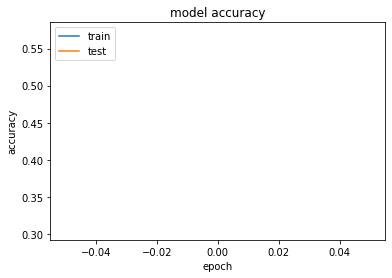

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


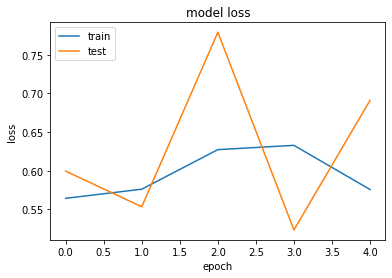

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Mejoras

- Data Augmentation

- Activación RELU entre capas de la arquitectura (Revisar arquitectura)

